# Codigos

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ORSTED"}}}

3 Failed downloads:
['IBE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-09-20 -> 2025-09-20)')
['PSON', 'ORSTED']: YFTzMissingError('possibly delisted; no timezone found')
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_47684\3694204178.py:37:FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Valor futuro estimado: 533798.66


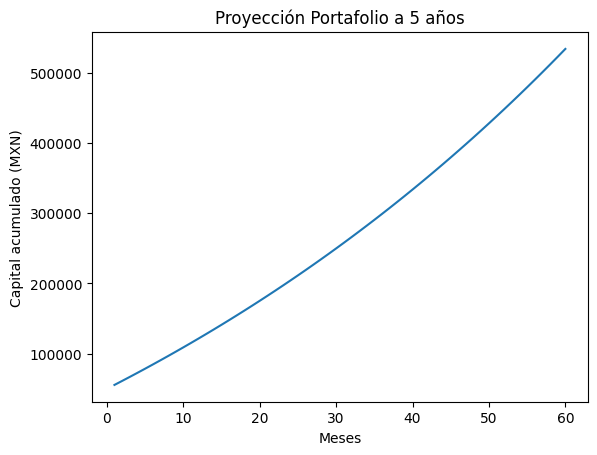

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# --- Configuración ---
rics = ["MSFT.O", "AAPL.O", "ORSTED.CO",
        "NVDA.O", "IBE.MC", "ICLN", "PSON.L", "CHGG.O"]  # Ejemplo: tecnología y energía sostenible
start_date = "2020-09-20"
end_date = "2025-09-20"

# Prepare tickers for yfinance by taking the part before the dot (e.g., 'MSFT' from 'MSFT.O')
short_tickers = [ric.split(".")[0] for ric in rics]

# Download historical close prices
data = yf.download(short_tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Extract Close prices and convert to long format like the original expected structure
if "Close" in data:
    close = data["Close"].copy()
else:
    # single ticker case: yf returns a Series for Close
    close = data["Close"].to_frame()

close = close.reset_index().melt(id_vars="Date", var_name="RIC", value_name="CLOSE")

# Map short tickers back to original RICs (e.g., 'MSFT' -> 'MSFT.O')
short_to_ric = {ric.split(".")[0]: ric for ric in rics}
close["RIC"] = close["RIC"].map(short_to_ric).fillna(close["RIC"])

prices = close  # match original variable name

# --- Calcular rendimientos anuales ---
df = prices.copy()
df["return"] = df.groupby("RIC")["CLOSE"].pct_change()
avg_returns = df.groupby("RIC")["return"].mean() * 252  # anualizar

# --- Supuesto: usamos promedio de portafolio ---
expected_return = avg_returns.mean()

# --- Simulación con aportaciones ---
P = 50000     # inversión inicial
C = 5000      # aportación mensual
r = expected_return / 12  # rendimiento mensual
n = 60        # meses

# Guardar contra division por cero si r es 0
if abs(r) < 1e-12:
    FV = P + C * n
else:
    FV = P * (1 + r) ** n + C * (((1 + r) ** n - 1) / r)

print("Valor futuro estimado:", round(FV, 2))

# --- Gráfico de crecimiento ---
values = []
balance = P
for i in range(1, n + 1):
    balance = balance * (1 + r) + C
    values.append(balance)

plt.plot(range(1, n + 1), values)
plt.title("Proyección Portafolio a 5 años")
plt.xlabel("Meses")
plt.ylabel("Capital acumulado (MXN)")
plt.show()


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $448,533.63 MXN
Rango de confianza del 95%: Entre $272,542.77 y $781,373.23 MXN


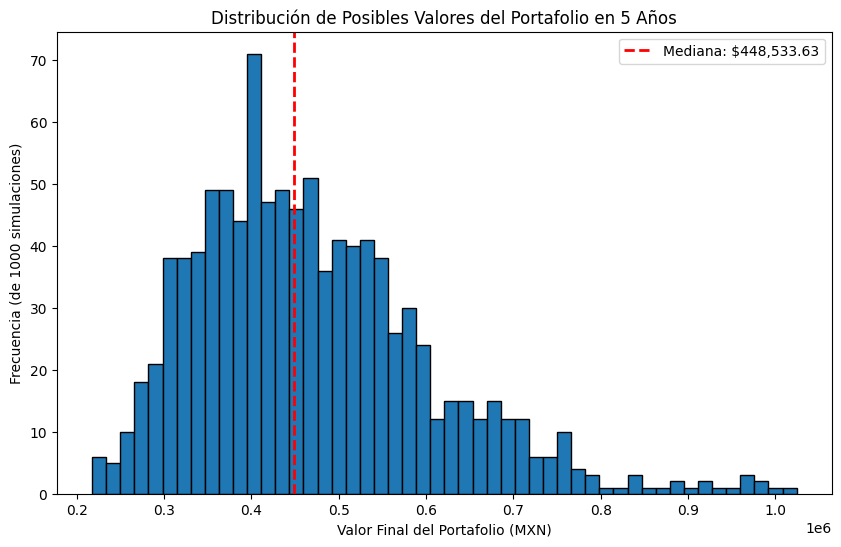

In [4]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración (Asegúrate de tener tu licencia activa) ---
ld.open_session()

# --- Parámetros de la Simulación para Emma ---
rics = ['ESGU.O', 'ICLN.O'] # Ejemplo: 60% S&P 500 ESG, 40% Energías Limpias
weights = np.array([0.6, 0.4])
initial_investment = 50000 # MXN (se asumirá como si fuera USD para el cálculo con RICS de USA)
monthly_contribution = 5000 # MXN
investment_horizon_years = 5
simulations = 1000 # Número de escenarios a simular

# --- Obtención de Datos Históricos (Últimos 5 años) ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose', # Precio de cierre ajustado por dividendos
    start=start_date,
    end=end_date
)

# --- Cálculo de Rendimientos y Matriz de Covarianza ---
daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
# Anualizar los rendimientos para la simulación
annual_mean_returns = mean_returns * 252
annual_cov_matrix = cov_matrix * 252

# --- Simulación de Monte Carlo ---
final_values = []
num_months = investment_horizon_years * 12

for i in range(simulations):
    total_value = initial_investment
    for month in range(num_months):
        # Cada mes, el portafolio crece y se añade la contribución
        # Se genera un rendimiento mensual aleatorio basado en la data histórica
        monthly_return = np.random.multivariate_normal(annual_mean_returns / 12, annual_cov_matrix / 12)
        portfolio_monthly_return = np.dot(monthly_return, weights)
        
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution
    final_values.append(total_value)

# --- Resultados ---
median_final_value = np.median(final_values)
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")

# --- Visualización (Opcional pero recomendado) ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, edgecolor='black')
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel('Frecuencia (de 1000 simulaciones)')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: ${median_final_value:,.2f}')
plt.legend()
plt.show()

ld.close_session()

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_47684\2657439069.py:36:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $660,795.51 MXN
Rango de confianza del 95%: Entre $444,385.24 y $1,038,625.23 MXN


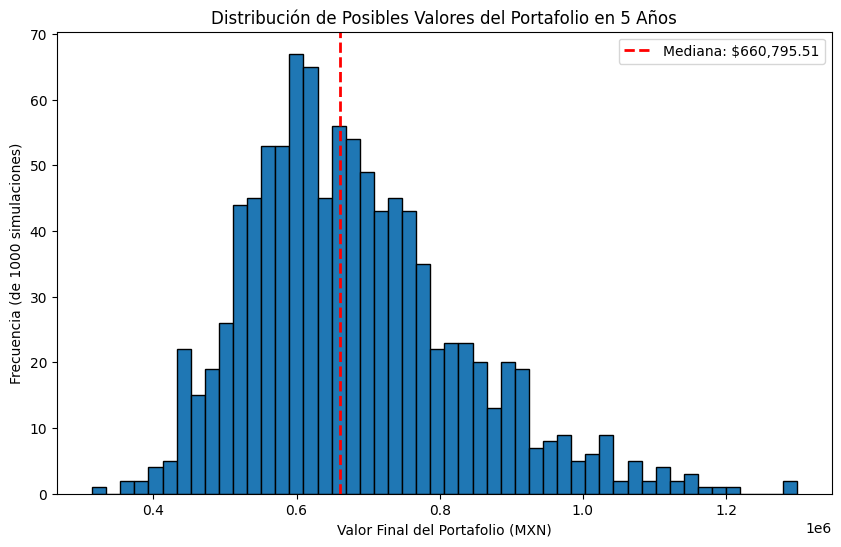

In [9]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración (Asegúrate de tener tu licencia activa) ---
ld.open_session()

# --- Parámetros de la Simulación para Emma ---
# Agregar tickers adicionales y asegurar unicidad
new_tickers = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", "ZOREN.IS",
    "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]
rics = list(dict.fromkeys(["ESGU.O", "ICLN.O"] + new_tickers))
#rics = ['ESGU.O', 'ICLN.O'] # Ejemplo: 60% S&P 500 ESG, 40% Energías Limpias
# Distribuir pesos uniformemente entre los 21 RICs
weights = np.ones(len(rics), dtype=float) / len(rics)
initial_investment = 50000 # MXN (se asumirá como si fuera USD para el cálculo con RICS de USA)
monthly_contribution = 5000 # MXN
investment_horizon_years = 5
simulations = 1000 # Número de escenarios a simular

# --- Obtención de Datos Históricos (Últimos 5 años) ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose', # Precio de cierre ajustado por dividendos
    start=start_date,
    end=end_date
)

# --- Cálculo de Rendimientos y Matriz de Covarianza ---
daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
# Anualizar los rendimientos para la simulación
annual_mean_returns = mean_returns * 252
annual_cov_matrix = cov_matrix * 252

# --- Simulación de Monte Carlo ---
final_values = []
num_months = investment_horizon_years * 12

for i in range(simulations):
    total_value = initial_investment
    for month in range(num_months):
        # Cada mes, el portafolio crece y se añade la contribución
        # Se genera un rendimiento mensual aleatorio basado en la data histórica
        monthly_return = np.random.multivariate_normal(annual_mean_returns / 12, annual_cov_matrix / 12)
        portfolio_monthly_return = np.dot(monthly_return, weights)
        
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution
    final_values.append(total_value)

# --- Resultados ---
median_final_value = np.median(final_values)
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")

# --- Visualización (Opcional pero recomendado) ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, edgecolor='black')
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel('Frecuencia (de 1000 simulaciones)')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: ${median_final_value:,.2f}')
plt.legend()
plt.show()


c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\2657439069.py:36:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $654,376.92 MXN
Rango de confianza del 95%: Entre $453,485.29 y $1,030,105.30 MXN


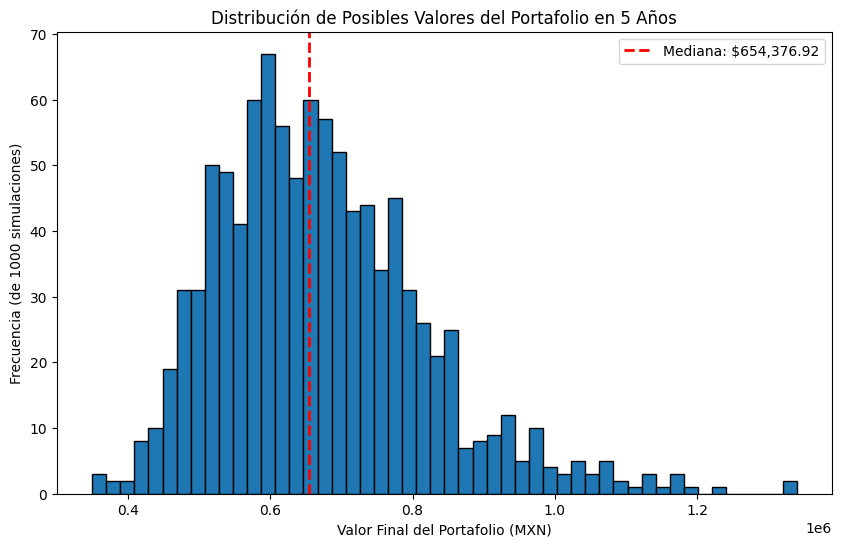

In [1]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración (Asegúrate de tener tu licencia activa) ---
ld.open_session()

# --- Parámetros de la Simulación para Emma ---
# Agregar tickers adicionales y asegurar unicidad
new_tickers = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", "ZOREN.IS",
    "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]
rics = list(dict.fromkeys(["ESGU.O", "ICLN.O"] + new_tickers))
#rics = ['ESGU.O', 'ICLN.O'] # Ejemplo: 60% S&P 500 ESG, 40% Energías Limpias

# Distribuir pesos uniformemente entre los 21 RICs
weights = np.ones(len(rics), dtype=float) / len(rics)
initial_investment = 50000 # MXN (se asumirá como si fuera USD para el cálculo con RICS de USA)
monthly_contribution = 5000 # MXN
investment_horizon_years = 5
simulations = 1000 # Número de escenarios a simular

# --- Obtención de Datos Históricos (Últimos 5 años) ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose', # Precio de cierre ajustado por dividendos
    start=start_date,
    end=end_date
)

# --- Cálculo de Rendimientos y Matriz de Covarianza ---
daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Anualizar los rendimientos para la simulación
annual_mean_returns = mean_returns * 252
annual_cov_matrix = cov_matrix * 252

# --- Simulación de Monte Carlo ---
final_values = []
num_months = investment_horizon_years * 12

for i in range(simulations):
    total_value = initial_investment
    for month in range(num_months):
        # Cada mes, el portafolio crece y se añade la contribución
        # Se genera un rendimiento mensual aleatorio basado en la data histórica
        monthly_return = np.random.multivariate_normal(annual_mean_returns / 12, annual_cov_matrix / 12)
        portfolio_monthly_return = np.dot(monthly_return, weights)
        
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution
    final_values.append(total_value)

# --- Resultados ---
median_final_value = np.median(final_values)
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")

# --- Visualización (Opcional pero recomendado) ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, edgecolor='black')
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel('Frecuencia (de 1000 simulaciones)')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: ${median_final_value:,.2f}')
plt.legend()
plt.show()


In [2]:
daily_returns

Price Close,ESGU.O,ICLN.O,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,REL.L,...,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,0.01107,0.005543,-0.002568,0.005939,0.029727,0.0,0.081731,-0.0048,-0.014141,0.010713,...,0.008267,0.025468,0.004538,0.007004,0.006536,0.026455,-0.003534,-0.01482,0.030392,0.09988
2021-10-04,-0.013461,-0.026183,-0.005517,0.017565,-0.003944,0.0,-0.016,0.0,-0.022541,-0.014286,...,-0.03423,-0.020719,-0.001063,0.01932,0.0,0.079897,0.018913,-0.002616,-0.010466,0.099562
2021-10-05,0.010488,0.001887,-0.003328,0.002683,-0.008552,0.0,-0.02168,0.001608,-0.002096,0.01122,...,0.015228,0.019957,-0.014366,-0.003033,0.012987,-0.050119,-0.017401,-0.024262,-0.0375,-0.038806
2021-10-06,0.004635,0.002354,-0.00705,0.00123,-0.00631,0.0,0.023084,0.011236,0.006303,-0.008322,...,0.002362,0.015064,0.008907,-0.007605,-0.032051,0.007538,-0.029516,-0.040995,-0.121878,-0.063147
2021-10-07,0.008425,0.010333,0.005232,0.01416,0.002492,0.0,-0.00361,0.001587,0.02714,0.00979,...,0.005836,0.005936,-0.00428,0.014559,0.006623,0.007481,0.003041,0.007708,-0.017065,0.00663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,0.004961,0.012525,-0.010766,-0.01354,0.004842,-0.001565,0.006234,0.097633,0.0,-0.003735,...,0.020598,-0.006719,-0.009832,0.013752,0.005376,0.014599,0.049526,0.079137,0.030223,0.032628
2025-09-23,-0.00569,-0.011068,0.008904,-0.009777,-0.009637,-0.007837,-0.009913,-0.013477,-0.003195,-0.009516,...,-0.004145,-0.010147,-0.001211,0.022287,-0.018717,-0.019185,-0.0251,0.001481,0.001276,0.007686
2025-09-24,-0.003103,-0.003292,-0.010051,0.01652,0.011121,0.019747,-0.002503,-0.043716,0.0,0.005531,...,-0.006279,0.001807,-0.015519,0.015166,-0.002725,0.06683,-0.010299,-0.011095,-0.017834,-0.016949


## Montecarlo

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\1611664256.py:32:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $670,002.25 MXN
Rango de confianza del 95%: Entre $454,757.06 y $1,053,387.28 MXN
Probabilidad de alcanzar al menos $500,000.00 MXN: 92.00%


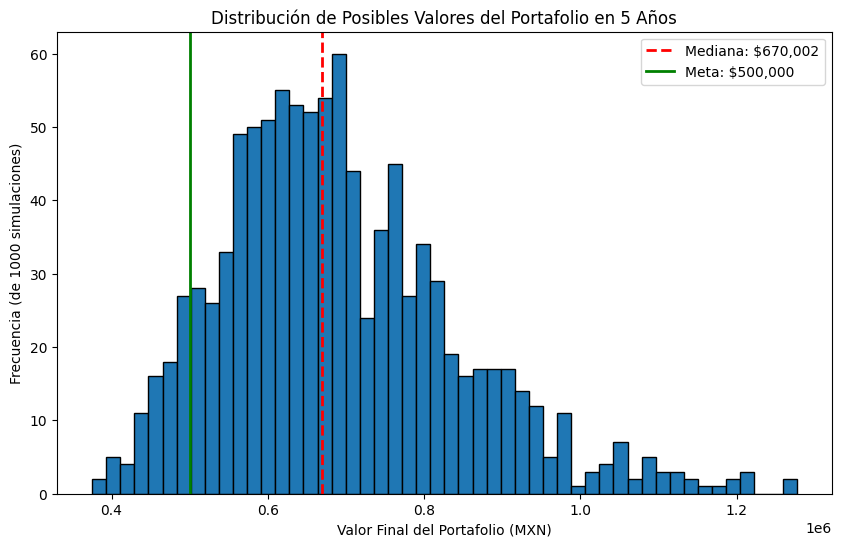

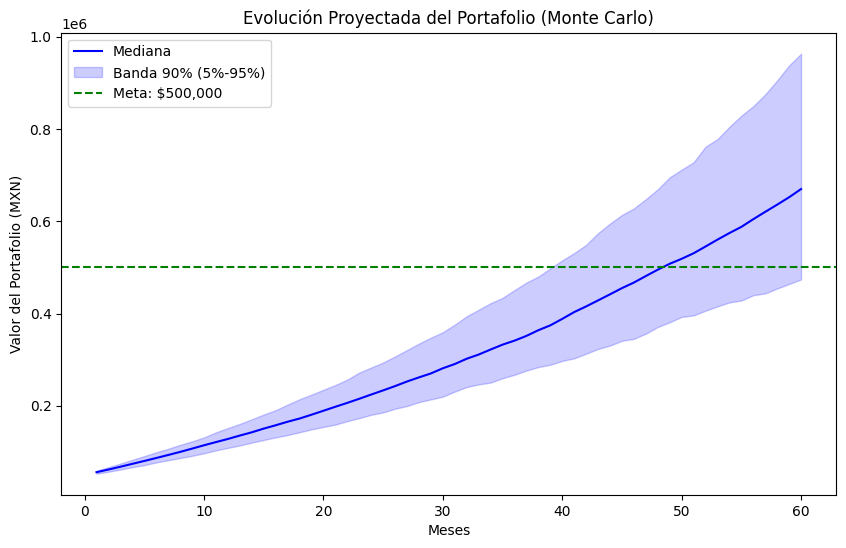

In [39]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración ---
ld.open_session()

rics = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "4901.T", "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", 
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]
weights = np.ones(len(rics), dtype=float) / len(rics)

initial_investment = 50000      # MXN
monthly_contribution = 5000     # MXN
investment_horizon_years = 5
simulations = 1000
meta_objetivo = 500000         # MXN (~25,000 EUR)

# --- Datos históricos ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose',
    start=start_date,
    end=end_date
)

daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

annual_mean_returns = mean_returns * 252
annual_cov_matrix = cov_matrix * 252

# --- Simulación Monte Carlo ---
num_months = investment_horizon_years * 12
trajectories = np.zeros((simulations, num_months))

for i in range(simulations):
    total_value = initial_investment
    for month in range(num_months):
        monthly_return = np.random.multivariate_normal(
            annual_mean_returns / 12,
            annual_cov_matrix / 12
        )
        portfolio_monthly_return = np.dot(monthly_return, weights)
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution
        trajectories[i, month] = total_value

final_values = trajectories[:, -1]

# --- Resultados ---
median_final_value = np.median(final_values)
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])
probabilidad_meta = np.mean(final_values >= meta_objetivo) * 100

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")
print(f"Probabilidad de alcanzar al menos ${meta_objetivo:,.2f} MXN: {probabilidad_meta:.2f}%")

# --- Visualización 1: Histograma ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, edgecolor='black')
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel('Frecuencia (de 1000 simulaciones)')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Mediana: ${median_final_value:,.0f}')
plt.axvline(meta_objetivo, color='green', linestyle='solid', linewidth=2,
            label=f'Meta: ${meta_objetivo:,.0f}')
plt.legend()
plt.show()

# --- Visualización 2: Curva de crecimiento con bandas ---
months = np.arange(1, num_months+1)
median_curve = np.percentile(trajectories, 50, axis=0)
p5_curve = np.percentile(trajectories, 5, axis=0)
p95_curve = np.percentile(trajectories, 95, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(months, median_curve, color='blue', label='Mediana')
plt.fill_between(months, p5_curve, p95_curve, color='blue', alpha=0.2,
                 label='Banda 90% (5%-95%)')
plt.axhline(meta_objetivo, color='green', linestyle='--',
            label=f'Meta: ${meta_objetivo:,.0f}')
plt.title('Evolución Proyectada del Portafolio (Monte Carlo)')
plt.xlabel('Meses')
plt.ylabel('Valor del Portafolio (MXN)')
plt.legend()
plt.show()

## Constante

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\1709584636.py:34:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Valor final proyectado (constante): $695,547.69 MXN


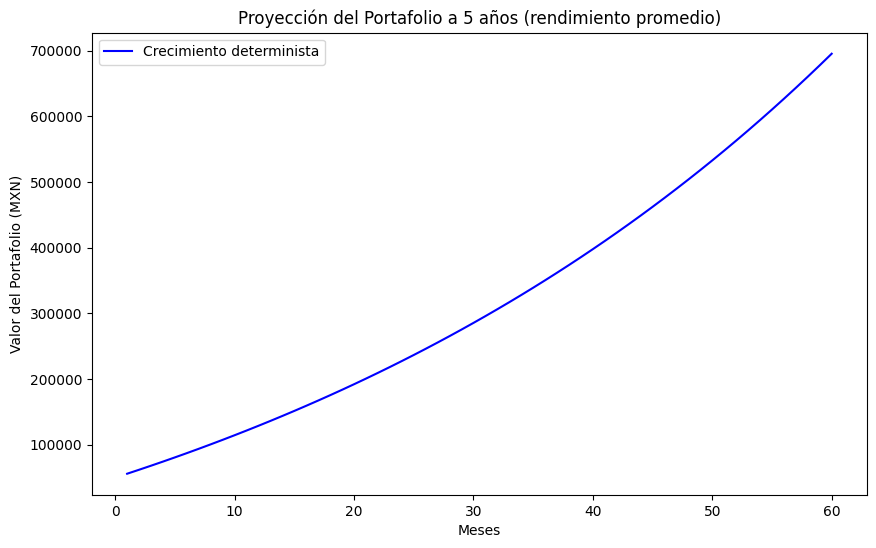

In [40]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración ---
ld.open_session()

# Agregar tickers adicionales y asegurar unicidad
rics = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "4901.T", "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", 
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]

weights = np.ones(len(rics)) / len(rics)    # pesos iguales

initial_investment = 50000      # MXN
monthly_contribution = 5000     # MXN
investment_horizon_years = 5
num_months = investment_horizon_years * 12

# --- Datos históricos ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose',
    start=start_date,
    end=end_date
)

# --- Rendimiento promedio ---
daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
portfolio_daily_mean = np.dot(mean_returns, weights)

# Escalar a mensual
monthly_mean_return = portfolio_daily_mean * 21  # ~21 días hábiles al mes

# --- Proyección determinista ---
values = []
total_value = initial_investment
for month in range(num_months):
    total_value = total_value * (1 + monthly_mean_return) + monthly_contribution
    values.append(total_value)

# --- Resultado final ---
print(f"Valor final proyectado (constante): ${total_value:,.2f} MXN")

# --- Gráfico ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_months+1), values, label='Crecimiento determinista', color='blue')
plt.title('Proyección del Portafolio a 5 años (rendimiento promedio)')
plt.xlabel('Meses')
plt.ylabel('Valor del Portafolio (MXN)')
plt.legend()
plt.show()


## Excel

In [41]:
import openpyxl
import lseg.data as ld
import numpy as np
import pandas as pd

# --- Configuración ---
ld.open_session()

# Agregar tickers adicionales y asegurar unicidad
rics = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "4901.T", "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", 
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]

weights = np.ones(len(rics)) / len(rics)

initial_investment = 50000
monthly_contribution = 5000
investment_horizon_years = 5
num_months = investment_horizon_years * 12

# --- Datos históricos ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose',
    start=start_date,
    end=end_date
)

# Rendimiento promedio diario y mensual
daily_returns = historical_data.pct_change().dropna()
mean_returns = daily_returns.mean()
portfolio_daily_mean = np.dot(mean_returns, weights)
monthly_mean_return = portfolio_daily_mean * 21  # ~21 días hábiles por mes

# --- Generar tabla ---
rows = []
total_value = initial_investment
for month in range(1, num_months+1):
    total_value = total_value * (1 + monthly_mean_return) + monthly_contribution
    rows.append([month, total_value])

df = pd.DataFrame(rows, columns=["Mes", "Valor_Portafolio"])
df.to_excel("proyeccion_constante.xlsx", index=False)

print("Archivo generado: proyeccion_constante.xlsx")


c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\2614029950.py:34:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Archivo generado: proyeccion_constante.xlsx


In [55]:
currency_info = ld.get_data(
    rics,
    fields=["TR.PriceClose", "TR.Currency"]
)
currency_info


,Instrument,Price Close
0,SGSN.S,81.0
1,FCN.N,161.52
2,EXLS.OQ,43.75
3,300012.SZ,12.71
4,QDT.PA,12.52
5,2301.TW,163.5
6,2353.TW,30.75
7,4901.T,3727.0
8,REL.L,3490.0
9,KBR.N,47.35


In [ ]:
import lseg.data as ld
import pandas as pd
import numpy as np

# --- Configuración ---
ld.open_session()

rics = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "4901.T", "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", 
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]

# --- Datos históricos (últimos 5 años) ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)

historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose',
    start=start_date,
    end=end_date
)

# --- Calcular rendimientos promedio MENSUALES ---
# Convertir a mensual con promedio del cierre
monthly_prices = historical_data.resample('M').mean()
daily_returns = monthly_prices.pct_change().dropna()  # rendimientos mensuales
mean_returns = daily_returns.mean()  # promedio mensual

# Convertir a anual (12 meses) y mantener mensual
annual_mean_returns = mean_returns * 12
monthly_mean_returns = mean_returns

# --- Crear DataFrame para exportar ---
df = pd.DataFrame({
    "Empresa": rics,
    "r anual": np.round(annual_mean_returns.values, 6),
    "r mensual": np.round(monthly_mean_returns.values, 6),
    "n = 60": [60]*len(rics)
})

# --- Exportar a Excel ---
df.to_excel("empresas_tasas2.xlsx", index=False)

print("Archivo generado: empresas_tasas2.xlsx")

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\1067283644.py:28:FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Archivo generado: empresas_tasas2.xlsx


In [43]:
historical_data

Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2020-09-28,99.64,108.92,13.096,24.25,10.42,45.9,24.9,1753.33158,1736.0,22.72,325.55,209.44,29.713334,21.04,1.426235,<NA>,1.330404,<NA>,<NA>,<NA>
2020-09-29,98.96,107.0,13.21,24.41,10.57,45.5,24.65,1756.66491,1723.5,22.7,323.64,207.26,29.333331,21.0,1.409651,<NA>,1.462893,<NA>,<NA>,<NA>
2020-09-30,98.76,105.97,13.194,24.43,11.56,46.1,24.8,1728.331605,1726.0,22.36,326.21,210.33,29.486794,21.46,1.426235,<NA>,1.608788,<NA>,<NA>,<NA>
2020-10-01,98.84,106.85,13.172,<NA>,11.1,<NA>,<NA>,<NA>,1722.5,22.17,332.34,212.46,29.852182,21.96,1.420707,<NA>,1.447909,<NA>,<NA>,<NA>
2020-10-02,99.16,108.0,13.248,<NA>,10.27,<NA>,<NA>,1719.331614,1747.0,22.43,321.89,206.19,29.289484,22.28,1.426235,<NA>,1.510999,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,80.86,159.55,43.58,12.76,16.14,185.5,31.3,3626.0,3468.0,48.66,702.09,514.45,41.29,20.64,3.74,25.02,9.96,13.5,7.84,58.55
2025-09-23,81.58,157.99,43.16,12.66,15.98,183.0,31.2,<NA>,3435.0,47.84,699.18,509.23,41.24,21.1,3.67,24.54,9.71,13.52,7.85,59.0
2025-09-24,80.76,160.6,43.64,12.91,15.94,175.0,31.2,3620.0,3454.0,49.51,694.79,510.15,40.6,21.42,3.66,26.18,9.61,13.37,7.71,58.0


In [44]:
daily_returns

Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2021-10-31,-0.039767,0.045746,0.011493,0.038447,-0.05767,0.011754,0.016461,-0.078043,0.003795,0.079263,0.002043,0.022461,-0.010462,0.104157,-0.030819,0.153575,-0.108829,-0.15396,-0.098454,0.040975
2021-11-30,0.036766,0.040217,0.074425,-0.01518,-0.039904,-0.018071,0.065648,0.030092,0.065931,0.059253,0.133768,0.106504,0.030793,0.065822,0.089802,0.153992,0.068765,0.004055,0.016893,0.010451
2021-12-31,0.0446,0.003141,0.023004,-0.045718,-0.081676,0.0135,0.100665,-0.059362,0.01567,0.021186,0.014623,-0.00912,-0.010478,-0.052358,0.030966,0.101428,0.154109,0.076102,-0.147818,0.096991
2022-01-31,-0.049233,0.011505,-0.05827,-0.071927,-0.018679,0.026584,0.013436,-0.058731,-0.055814,0.012415,-0.139931,-0.072311,-0.006584,-0.076646,-0.006133,0.281071,0.122253,0.008919,-0.186053,-0.003191
2022-02-28,-0.0763,-0.027108,-0.069587,-0.125238,-0.078404,0.062391,-0.029721,-0.06533,0.006747,-0.017112,-0.060925,-0.03243,0.050044,-0.05478,-0.073175,0.073781,0.099321,-0.005775,0.086921,0.009458
2022-03-31,-0.00122,0.038301,0.101974,-0.058577,-0.04777,0.014143,0.006328,-0.053689,0.001386,0.175789,-0.115333,-0.009975,0.031547,0.160387,0.008836,-0.115666,-0.012231,-0.027854,0.152189,-0.068655
2022-04-30,-0.029426,0.067096,0.098762,0.067341,0.038115,-0.023013,-0.040588,0.023175,0.067124,0.00137,0.006125,-0.023463,0.062572,0.10472,0.256672,0.107895,0.24287,0.159182,-0.013235,0.078228
2022-05-31,-0.037804,0.016101,-0.071836,0.025632,0.094468,-0.058057,0.000787,-0.041663,-0.049171,-0.123504,-0.171344,-0.076457,-0.005708,0.012201,-0.002211,-0.010395,-0.000341,-0.052383,-0.11551,-0.008961
2022-06-30,-0.094643,0.032013,0.072804,0.064937,0.000891,-0.048136,-0.0427,0.016028,-0.057643,0.02691,0.016901,-0.027106,-0.025513,-0.043069,0.007866,0.113613,0.008112,-0.016968,-0.063273,0.327818


In [45]:
mean_returns

Price Close
SGSN.S      -0.005636
FCN.N        0.005409
EXLS.OQ      0.013828
300012.SZ   -0.011519
QDT.PA      -0.005891
2301.TW      0.022823
2353.TW        0.0069
4901.T       0.004188
REL.L        0.010278
KBR.N        0.006474
INTU.OQ      0.006075
MSFT.OQ      0.012762
EGIE3.SA     0.006774
ERG.MI      -0.002754
ZOREN.IS     0.038353
GWIND.IS     0.051707
NATEN.IS     0.053444
ESEN.IS       0.05735
RNW.OQ      -0.002109
MAGEN.IS     0.076006
dtype: Float64

In [46]:
monthly_mean_returns

Price Close
SGSN.S      -0.005636
FCN.N        0.005409
EXLS.OQ      0.013828
300012.SZ   -0.011519
QDT.PA      -0.005891
2301.TW      0.022823
2353.TW        0.0069
4901.T       0.004188
REL.L        0.010278
KBR.N        0.006474
INTU.OQ      0.006075
MSFT.OQ      0.012762
EGIE3.SA     0.006774
ERG.MI      -0.002754
ZOREN.IS     0.038353
GWIND.IS     0.051707
NATEN.IS     0.053444
ESEN.IS       0.05735
RNW.OQ      -0.002109
MAGEN.IS     0.076006
dtype: Float64

In [47]:
df

,Empresa,r anual,r mensual,n = 60
0,SGSN.S,-0.067629,-0.005636,60
1,FCN.N,0.064906,0.005409,60
2,EXLS.OQ,0.165933,0.013828,60
3,300012.SZ,-0.138226,-0.011519,60
4,QDT.PA,-0.070696,-0.005891,60
5,2301.TW,0.273877,0.022823,60
6,2353.TW,0.082804,0.0069,60
7,4901.T,0.05026,0.004188,60
8,REL.L,0.12334,0.010278,60
9,KBR.N,0.077689,0.006474,60


In [48]:
daily_returns

Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2021-10-31,-0.039767,0.045746,0.011493,0.038447,-0.05767,0.011754,0.016461,-0.078043,0.003795,0.079263,0.002043,0.022461,-0.010462,0.104157,-0.030819,0.153575,-0.108829,-0.15396,-0.098454,0.040975
2021-11-30,0.036766,0.040217,0.074425,-0.01518,-0.039904,-0.018071,0.065648,0.030092,0.065931,0.059253,0.133768,0.106504,0.030793,0.065822,0.089802,0.153992,0.068765,0.004055,0.016893,0.010451
2021-12-31,0.0446,0.003141,0.023004,-0.045718,-0.081676,0.0135,0.100665,-0.059362,0.01567,0.021186,0.014623,-0.00912,-0.010478,-0.052358,0.030966,0.101428,0.154109,0.076102,-0.147818,0.096991
2022-01-31,-0.049233,0.011505,-0.05827,-0.071927,-0.018679,0.026584,0.013436,-0.058731,-0.055814,0.012415,-0.139931,-0.072311,-0.006584,-0.076646,-0.006133,0.281071,0.122253,0.008919,-0.186053,-0.003191
2022-02-28,-0.0763,-0.027108,-0.069587,-0.125238,-0.078404,0.062391,-0.029721,-0.06533,0.006747,-0.017112,-0.060925,-0.03243,0.050044,-0.05478,-0.073175,0.073781,0.099321,-0.005775,0.086921,0.009458
2022-03-31,-0.00122,0.038301,0.101974,-0.058577,-0.04777,0.014143,0.006328,-0.053689,0.001386,0.175789,-0.115333,-0.009975,0.031547,0.160387,0.008836,-0.115666,-0.012231,-0.027854,0.152189,-0.068655
2022-04-30,-0.029426,0.067096,0.098762,0.067341,0.038115,-0.023013,-0.040588,0.023175,0.067124,0.00137,0.006125,-0.023463,0.062572,0.10472,0.256672,0.107895,0.24287,0.159182,-0.013235,0.078228
2022-05-31,-0.037804,0.016101,-0.071836,0.025632,0.094468,-0.058057,0.000787,-0.041663,-0.049171,-0.123504,-0.171344,-0.076457,-0.005708,0.012201,-0.002211,-0.010395,-0.000341,-0.052383,-0.11551,-0.008961
2022-06-30,-0.094643,0.032013,0.072804,0.064937,0.000891,-0.048136,-0.0427,0.016028,-0.057643,0.02691,0.016901,-0.027106,-0.025513,-0.043069,0.007866,0.113613,0.008112,-0.016968,-0.063273,0.327818


In [49]:
historical_data

Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2020-09-28,99.64,108.92,13.096,24.25,10.42,45.9,24.9,1753.33158,1736.0,22.72,325.55,209.44,29.713334,21.04,1.426235,<NA>,1.330404,<NA>,<NA>,<NA>
2020-09-29,98.96,107.0,13.21,24.41,10.57,45.5,24.65,1756.66491,1723.5,22.7,323.64,207.26,29.333331,21.0,1.409651,<NA>,1.462893,<NA>,<NA>,<NA>
2020-09-30,98.76,105.97,13.194,24.43,11.56,46.1,24.8,1728.331605,1726.0,22.36,326.21,210.33,29.486794,21.46,1.426235,<NA>,1.608788,<NA>,<NA>,<NA>
2020-10-01,98.84,106.85,13.172,<NA>,11.1,<NA>,<NA>,<NA>,1722.5,22.17,332.34,212.46,29.852182,21.96,1.420707,<NA>,1.447909,<NA>,<NA>,<NA>
2020-10-02,99.16,108.0,13.248,<NA>,10.27,<NA>,<NA>,1719.331614,1747.0,22.43,321.89,206.19,29.289484,22.28,1.426235,<NA>,1.510999,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-22,80.86,159.55,43.58,12.76,16.14,185.5,31.3,3626.0,3468.0,48.66,702.09,514.45,41.29,20.64,3.74,25.02,9.96,13.5,7.84,58.55
2025-09-23,81.58,157.99,43.16,12.66,15.98,183.0,31.2,<NA>,3435.0,47.84,699.18,509.23,41.24,21.1,3.67,24.54,9.71,13.52,7.85,59.0
2025-09-24,80.76,160.6,43.64,12.91,15.94,175.0,31.2,3620.0,3454.0,49.51,694.79,510.15,40.6,21.42,3.66,26.18,9.61,13.37,7.71,58.0


In [50]:
monthly_prices = historical_data.resample('M').mean()
monthly_returns = monthly_prices.pct_change().dropna()  # ahora son rendimientos mensuales
monthly_returns

C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\3947906059.py:1:FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2021-10-31,-0.039767,0.045746,0.011493,0.038447,-0.05767,0.011754,0.016461,-0.078043,0.003795,0.079263,0.002043,0.022461,-0.010462,0.104157,-0.030819,0.153575,-0.108829,-0.15396,-0.098454,0.040975
2021-11-30,0.036766,0.040217,0.074425,-0.01518,-0.039904,-0.018071,0.065648,0.030092,0.065931,0.059253,0.133768,0.106504,0.030793,0.065822,0.089802,0.153992,0.068765,0.004055,0.016893,0.010451
2021-12-31,0.0446,0.003141,0.023004,-0.045718,-0.081676,0.0135,0.100665,-0.059362,0.01567,0.021186,0.014623,-0.00912,-0.010478,-0.052358,0.030966,0.101428,0.154109,0.076102,-0.147818,0.096991
2022-01-31,-0.049233,0.011505,-0.05827,-0.071927,-0.018679,0.026584,0.013436,-0.058731,-0.055814,0.012415,-0.139931,-0.072311,-0.006584,-0.076646,-0.006133,0.281071,0.122253,0.008919,-0.186053,-0.003191
2022-02-28,-0.0763,-0.027108,-0.069587,-0.125238,-0.078404,0.062391,-0.029721,-0.06533,0.006747,-0.017112,-0.060925,-0.03243,0.050044,-0.05478,-0.073175,0.073781,0.099321,-0.005775,0.086921,0.009458
2022-03-31,-0.00122,0.038301,0.101974,-0.058577,-0.04777,0.014143,0.006328,-0.053689,0.001386,0.175789,-0.115333,-0.009975,0.031547,0.160387,0.008836,-0.115666,-0.012231,-0.027854,0.152189,-0.068655
2022-04-30,-0.029426,0.067096,0.098762,0.067341,0.038115,-0.023013,-0.040588,0.023175,0.067124,0.00137,0.006125,-0.023463,0.062572,0.10472,0.256672,0.107895,0.24287,0.159182,-0.013235,0.078228
2022-05-31,-0.037804,0.016101,-0.071836,0.025632,0.094468,-0.058057,0.000787,-0.041663,-0.049171,-0.123504,-0.171344,-0.076457,-0.005708,0.012201,-0.002211,-0.010395,-0.000341,-0.052383,-0.11551,-0.008961
2022-06-30,-0.094643,0.032013,0.072804,0.064937,0.000891,-0.048136,-0.0427,0.016028,-0.057643,0.02691,0.016901,-0.027106,-0.025513,-0.043069,0.007866,0.113613,0.008112,-0.016968,-0.063273,0.327818


In [51]:
months_full = monthly_prices.pct_change()
months_full

Price Close,SGSN.S,FCN.N,EXLS.OQ,300012.SZ,QDT.PA,2301.TW,2353.TW,4901.T,REL.L,KBR.N,INTU.OQ,MSFT.OQ,EGIE3.SA,ERG.MI,ZOREN.IS,GWIND.IS,NATEN.IS,ESEN.IS,RNW.OQ,MAGEN.IS
Date,,,,,,,,,,,,,,,,,,,,
2020-09-30,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-10-31,-0.028707,0.025131,0.090005,0.082339,0.062128,0.000134,-0.00984,0.01189,-0.037184,0.050913,0.025816,0.018566,0.008372,0.015426,0.05781,<NA>,0.032349,<NA>,<NA>,<NA>
2020-11-30,0.062952,-0.058514,0.1347,-0.008157,0.146212,0.042198,-0.062346,0.059598,0.042798,0.100906,0.045429,0.005865,0.060498,-0.041069,-0.014188,<NA>,-0.09765,0.139402,<NA>,<NA>
2020-12-31,0.020841,0.053596,0.042488,-0.018483,0.231697,0.027805,0.034165,-0.009522,0.03161,0.111275,0.064389,0.017858,0.021044,0.027366,0.002596,<NA>,0.000613,0.000484,<NA>,<NA>
2021-01-31,0.038462,0.046696,-0.003093,0.105981,0.050091,0.091092,0.043048,0.082832,0.03038,0.058006,0.001024,0.018407,0.011504,0.199792,0.104782,<NA>,0.073429,0.296721,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.085978,0.016107,0.028878,-0.032552,0.078438,0.150533,0.085781,0.159227,0.051935,0.059667,0.136301,0.184824,0.04368,0.029853,-0.04622,-0.097146,0.103971,0.297735,0.089184,0.086353
2025-06-30,-0.019393,-0.024122,-0.002792,0.01369,-0.07376,0.057966,-0.024379,-0.02462,-0.031383,-0.047437,0.134307,0.067863,0.022272,0.048057,-0.087361,-0.045613,0.023611,0.351984,0.020917,0.094161
2025-07-31,-0.005772,0.032847,-0.058396,0.056315,0.027992,0.089977,-0.096205,-0.02186,0.001279,-0.083484,0.008928,0.057974,0.0325,0.003731,0.090958,0.112726,-0.047071,0.217997,0.102757,0.10982


### Exportar excel bueno

In [52]:
# --- Exportar a Excel ---
months_full.to_excel("Empresas_Rendimientos_Mensuales.xlsx", index=False)
print("Archivo generado: Empresas_Rendimientos_Mensuales.xlsx")

Archivo generado: Empresas_Rendimientos_Mensuales.xlsx


In [53]:
# Obtener sus columnas
months_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2020-09-30 to 2025-09-30
Freq: ME
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SGSN.S     60 non-null     Float64
 1   FCN.N      60 non-null     Float64
 2   EXLS.OQ    60 non-null     Float64
 3   300012.SZ  60 non-null     Float64
 4   QDT.PA     60 non-null     Float64
 5   2301.TW    60 non-null     Float64
 6   2353.TW    60 non-null     Float64
 7   4901.T     60 non-null     Float64
 8   REL.L      60 non-null     Float64
 9   KBR.N      60 non-null     Float64
 10  INTU.OQ    60 non-null     Float64
 11  MSFT.OQ    60 non-null     Float64
 12  EGIE3.SA   60 non-null     Float64
 13  ERG.MI     60 non-null     Float64
 14  ZOREN.IS   60 non-null     Float64
 15  GWIND.IS   53 non-null     Float64
 16  NATEN.IS   60 non-null     Float64
 17  ESEN.IS    59 non-null     Float64
 18  RNW.OQ     56 non-null     Float64
 19  MAGEN.IS   48 non-null 

# Nuevo Intento

- 7 EXLS.OQ
- 10 4901.T
- 5 2301.TW
- 9 REL.L
- 8 MSFT.OQ
- 6 ZOREN.IS
- 4 GWIND.IS
- 3 NATEN.IS
- 2 ESEN.IS
- 1 MAGEN.IS


## Mensual

EXLS.OQ
4901.T
2301.TW
REL.L
MSFT.OQ
ZOREN.IS
GWIND.IS
NATEN.IS
ESEN.IS
MAGEN.IS

0.09
0.08
0.09
0.09
0.18
0.05
0.10
0.10
0.10
0.12

4901.T
2301.TW
ZOREN.IS
GWIND.IS
NATEN.IS
ESEN.IS
MAGEN.IS

0.09
0.09
0.06
0.10
0.11
0.20
0.36


In [4]:
daily_returns

Price Close,MAGEN.IS,GWIND.IS,NATEN.IS,ESEN.IS,MSFT.OQ,ZOREN.IS,EXLS.OQ,4901.T,2301.TW,REL.L
Date,,,,,,,,,,
2021-10-01,0.09988,0.026455,-0.003534,-0.01482,0.025468,0.006536,0.029727,-0.023135,-0.0048,0.010713
2021-10-04,0.099562,0.079897,0.018913,-0.002616,-0.020719,0.0,-0.003944,-0.059155,0.0,-0.014286
2021-10-05,-0.038806,-0.050119,-0.017401,-0.024262,0.019957,0.012987,-0.008552,-0.012755,0.001608,0.01122
2021-10-06,-0.063147,0.007538,-0.029516,-0.040995,0.015064,-0.032051,-0.00631,-0.010976,0.011236,-0.008322
2021-10-07,0.00663,0.007481,0.003041,0.007708,0.005936,0.006623,0.002492,-0.009017,0.001587,0.00979
...,...,...,...,...,...,...,...,...,...,...
2025-09-22,0.032628,0.014599,0.049526,0.079137,-0.006719,0.005376,0.004842,0.020259,0.097633,-0.003735
2025-09-23,0.007686,-0.019185,-0.0251,0.001481,-0.010147,-0.018717,-0.009637,0.0,-0.013477,-0.009516
2025-09-24,-0.016949,0.06683,-0.010299,-0.011095,0.001807,-0.002725,0.011121,-0.001655,-0.043716,0.005531


c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_22500\4122816741.py:44:FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


Resultados de la Simulación de Monte Carlo a 5 años:
Valor final mediano proyectado: $2,819,287.94 MXN
Rango de confianza del 95%: Entre $876,391.84 y $10,230,137.55 MXN
Probabilidad de alcanzar al menos $500,000.00 MXN: 100.00%


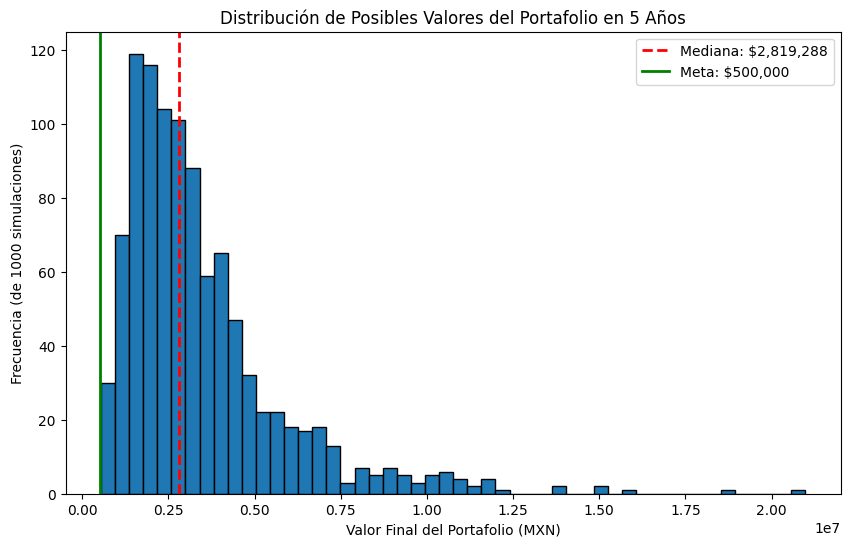

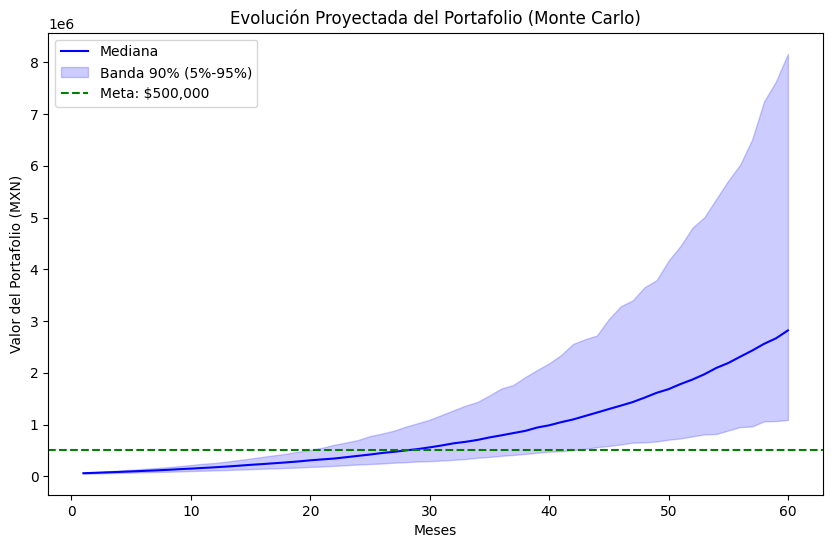

In [ ]:
import lseg.data as ld
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuración ---
ld.open_session()

# Capital inicial (inversión única al inicio)
initial_rics = [
    "EXLS.OQ", "4901.T", "2301.TW", "REL.L", "MSFT.OQ",
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "MAGEN.IS"
]
initial_weights = np.array([0.09, 0.08, 0.09, 0.09, 0.18, 0.05, 0.10, 0.10, 0.10, 0.12]) 

# Aportaciones mensuales (se reparten diferente)
monthly_rics = [
    "4901.T", "2301.TW", "ZOREN.IS", "GWIND.IS", 
    "NATEN.IS", "ESEN.IS", "MAGEN.IS"
]
monthly_weights = np.array([0.09, 0.09, 0.06, 0.10, 0.11, 0.20, 0.36])


initial_investment = 50000      # MXN
monthly_contribution = 5000     # MXN
investment_horizon_years = 5    # 5 años
simulations = 1000  # Número de escenarios a simular
meta_objetivo = 500000          # MXN (~25,000 EUR)

# --- Datos históricos ---
end_date = pd.to_datetime('today')  # hasta hoy
start_date = end_date - pd.DateOffset(years=5) # últimos 5 años
all_rics = list(set(initial_rics + monthly_rics))  # unión de ambas listas

historical_data = ld.get_history(
    all_rics,   # todos los RICs necesarios
    fields='TR.PriceClose', # Precio de cierre ajustado por dividendos
    start=start_date, # 5 años atrás
    end=end_date # hasta hoy
)

# --- Rendimientos ---
daily_returns = historical_data.pct_change().dropna() # aqui lo que sucede 
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

annual_mean_returns = mean_returns * 252 # anualizar (252 días hábiles)
annual_cov_matrix = cov_matrix * 252 # anualizar (252 días hábiles)

# --- Simulación Monte Carlo ---
num_months = investment_horizon_years * 12
trajectories = np.zeros((simulations, num_months))

for i in range(simulations):
    # Inversión inicial: distribuida según initial_weights
    init_returns = np.random.multivariate_normal(
        annual_mean_returns[initial_rics] / 12,
        annual_cov_matrix.loc[initial_rics, initial_rics] / 12
    )
    initial_value = np.dot(init_returns, initial_weights)  # rendimiento inicial
    total_value = initial_investment * (1 + initial_value)

    for month in range(num_months):
        # Simular aportaciones con monthly_rics
        monthly_return = np.random.multivariate_normal(
            annual_mean_returns[monthly_rics] / 12,
            annual_cov_matrix.loc[monthly_rics, monthly_rics] / 12
        )
        portfolio_monthly_return = np.dot(monthly_return, monthly_weights)

        # Portafolio crece y se agregan las aportaciones en base a monthly_weights
        total_value = total_value * (1 + portfolio_monthly_return) + monthly_contribution
        trajectories[i, month] = total_value

final_values = trajectories[:, -1]

# --- Resultados ---
median_final_value = np.median(final_values)
confidence_interval_95 = np.percentile(final_values, [2.5, 97.5])
probabilidad_meta = np.mean(final_values >= meta_objetivo) * 100

print(f"Resultados de la Simulación de Monte Carlo a {investment_horizon_years} años:")
print(f"Valor final mediano proyectado: ${median_final_value:,.2f} MXN")
print(f"Rango de confianza del 95%: Entre ${confidence_interval_95[0]:,.2f} y ${confidence_interval_95[1]:,.2f} MXN")
print(f"Probabilidad de alcanzar al menos ${meta_objetivo:,.2f} MXN: {probabilidad_meta:.2f}%")

# --- Visualización 1: Histograma ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, edgecolor='black')
plt.title('Distribución de Posibles Valores del Portafolio en 5 Años')
plt.xlabel('Valor Final del Portafolio (MXN)')
plt.ylabel('Frecuencia (de 1000 simulaciones)')
plt.axvline(median_final_value, color='red', linestyle='dashed', linewidth=2,
            label=f'Mediana: ${median_final_value:,.0f}')
plt.axvline(meta_objetivo, color='green', linestyle='solid', linewidth=2,
            label=f'Meta: ${meta_objetivo:,.0f}')
plt.legend()
plt.show()

# --- Visualización 2: Curva de crecimiento con bandas ---
months = np.arange(1, num_months+1)
median_curve = np.percentile(trajectories, 50, axis=0)
p5_curve = np.percentile(trajectories, 5, axis=0)
p95_curve = np.percentile(trajectories, 95, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(months, median_curve, color='blue', label='Mediana')
plt.fill_between(months, p5_curve, p95_curve, color='blue', alpha=0.2,
                 label='Banda 90% (5%-95%)')
plt.axhline(meta_objetivo, color='green', linestyle='--',
            label=f'Meta: ${meta_objetivo:,.0f}')
plt.title('Evolución Proyectada del Portafolio (Monte Carlo)')
plt.xlabel('Meses')
plt.ylabel('Valor del Portafolio (MXN)')
plt.legend()
plt.show()


## Currency

In [57]:
import lseg.data as ld
import pandas as pd
import numpy as np

# --- Sesión ---
ld.open_session()

# --- RICs ---
rics = [
    "SGSN.S", "FCN.N", "EXLS.OQ", "300012.SZ", "QDT.PA", "2301.TW", "2353.TW",
    "4901.T", "REL.L", "KBR.N", "INTU.OQ", "MSFT.OQ", "EGIE3.SA", "ERG.MI", 
    "ZOREN.IS", "GWIND.IS", "NATEN.IS", "ESEN.IS", "RNW.OQ", "MAGEN.IS"
]

# --- Fechas ---
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=5)

# --- 1. Detectar moneda de cada RIC ---
# Robust attempt to get currency info: try several call variants and handle missing data
currency_info = None
for fields_variant in (["TR.Currency"], "TR.Currency", ["TR.PriceClose", "TR.Currency"]):
    try:
        currency_info = ld.get_data(rics, fields=fields_variant)
        # stop if we got a non-empty result
        if currency_info is not None and hasattr(currency_info, "empty") and not currency_info.empty:
            break
    except Exception:
        # try next variant
        currency_info = None

# Validate result and build a safe currency map (default to MXN when unknown)
if currency_info is None or (hasattr(currency_info, "empty") and currency_info.empty) or "Currency" not in currency_info.columns:
    print("⚠️ No se obtuvo la información de moneda completa. Se asumirá 'MXN' para los RICs sin dato.")
    currency_map = {ric: "MXN" for ric in rics}
else:
    currency_map = currency_info.set_index("Instrument")["Currency"].to_dict()
    # fill missing/malformed entries with MXN
    for ric in rics:
        if ric not in currency_map or pd.isna(currency_map[ric]):
            currency_map[ric] = "MXN"

print("Monedas detectadas (con valores por defecto si faltan):\n", currency_map)

# --- 2. Descargar precios históricos ---
historical_data = ld.get_history(
    rics,
    fields='TR.PriceClose',
    start=start_date,
    end=end_date
)

# --- 3. Definir mapa de moneda -> RIC de FX vs MXN ---
fx_map = {
    "USD": "MXN=",      # USD/MXN
    "EUR": "EURMXN=",   # EUR/MXN
    "CHF": "CHF=MXN",   # CHF/MXN
    "GBP": "GBPMXN=",   # GBP/MXN
    "BRL": "BRLMXN=",   # BRL/MXN
    "TRY": "TRYMXN=",   # Lira turca/MXN
    "TWD": "TWD=MXN",   # Nuevo dólar taiwanés/MXN
    "JPY": "JPYMXN=",   # Yen/MXN
    "CNY": "CNYMXN="    # Yuan/MXN
}

# Monedas únicas en tu portafolio
monedas = set(currency_map.values())

# --- 4. Descargar FX correspondientes ---
fx_rics = [fx_map[m] for m in monedas if m in fx_map]
fx_data = ld.get_history(
    fx_rics,
    fields="TR.MIDPRICE",
    start=start_date,
    end=end_date
).resample("M").mean()

# --- 5. Convertir precios originales a MXN ---
monthly_prices = historical_data.resample('M').mean()

prices_mxn = pd.DataFrame(index=monthly_prices.index)

for ric in rics:
    moneda = currency_map[ric]
    if moneda == "MXN":
        # ya está en pesos
        prices_mxn[ric] = monthly_prices[ric]
    else:
        fx_ric = fx_map.get(moneda)
        if fx_ric in fx_data.columns:
            prices_mxn[ric] = monthly_prices[ric] * fx_data[fx_ric]
        else:
            print(f"⚠️ No encontré tipo de cambio para {ric} ({moneda}), se deja en moneda original")
            prices_mxn[ric] = monthly_prices[ric]

# --- 6. Calcular rendimientos en pesos (MXN) ---
returns_mxn = prices_mxn.pct_change().dropna()
mean_monthly_returns = returns_mxn.mean()
annualized_returns = mean_monthly_returns * 12

print("\nRendimientos promedio anuales en MXN:")
print(annualized_returns)


⚠️ No se obtuvo la información de moneda completa. Se asumirá 'MXN' para los RICs sin dato.
Monedas detectadas (con valores por defecto si faltan):
 {'SGSN.S': 'MXN', 'FCN.N': 'MXN', 'EXLS.OQ': 'MXN', '300012.SZ': 'MXN', 'QDT.PA': 'MXN', '2301.TW': 'MXN', '2353.TW': 'MXN', '4901.T': 'MXN', 'REL.L': 'MXN', 'KBR.N': 'MXN', 'INTU.OQ': 'MXN', 'MSFT.OQ': 'MXN', 'EGIE3.SA': 'MXN', 'ERG.MI': 'MXN', 'ZOREN.IS': 'MXN', 'GWIND.IS': 'MXN', 'NATEN.IS': 'MXN', 'ESEN.IS': 'MXN', 'RNW.OQ': 'MXN', 'MAGEN.IS': 'MXN'}


c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\Juan Marco\AppData\Local\Temp\ipykernel_20852\3740213203.py:76:FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'